In [35]:
import random

random_seed = 10
random.seed(random_seed)

In [36]:
!pip install gensim

In [37]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [38]:
from nltk.corpus import stopwords
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim.models.phrases import Phrases, Phraser
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')


from google.colab import drive
drive.mount('/content/gdrive')
df = pd.read_csv('/content/gdrive/MyDrive/DATA/palm_oil_grievance_logs.csv')
df

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,pk,source,internal_id,status,submitted_on,accepted_on,last_updated_on,country,region,complainants,respondents,respondent_sector,respondent_parent_company,respondent_supplier,summary,history,external_link,extras
0,1,Roundtable on Sustainable Palm Oil (RSPO),500Mg00000L0di6IAB,Closed,2/26/2025,4/15/2025,5/20/2025,Indonesia,Sumatera Selatan,Confidential,PT Sawit Mas Sejahtera,Oil Palm Growers,Golden Agri-Resources (GAR),NaN,That the Respondent allegedly transferred the ...,2025-05-20: CP's Decision Letter dated 20. 05....,https://rspo.my.site.com/Complaint/s/case/500M...,{'case_number': 'RSPO/2025/02/RR'}
1,2,Roundtable on Sustainable Palm Oil (RSPO),500GB00003xVwYqYAK,In Progress - Investigation,11/29/2024,1/16/2025,1/16/2025,Mexico,NaN,Confidential,INDUSTRIAS OLEOPALMA S.A. DE C.V.,Oil Palm Growers,Oleoquímica Mexicana S.A. de C.V.,NaN,The Complainant alleges that the Respondent ha...,2025-04-30: The Secretariat furnished the Resp...,https://rspo.my.site.com/Complaint/s/case/500G...,{'case_number': 'RSPO/2024/17/MAM'}
2,3,Roundtable on Sustainable Palm Oil (RSPO),500GB00003xVxmPYAS,In Progress - Investigation,11/28/2024,1/21/2025,1/21/2025,Colombia,Montes de María,Confidential,OLEOFLORES S A S,Processors and/or Traders,Musim Mas Holdings Pte.,NaN,1.The Complainant alleges that the Respondent ...,2025-04-30: The Complaints Panels directive to...,https://rspo.my.site.com/Complaint/s/case/500G...,{'case_number': 'RSPO/2024/18/HN'}
3,4,Roundtable on Sustainable Palm Oil (RSPO),500GB00003xVGg2YAG,In Progress - Investigation,10/16/2024,11/18/2024,11/18/2024,Indonesia,Riau,S. Samsul Hadi,PT Guntung Idamannusa,Oil Palm Growers,Compañía Industrial Aceitera Coto Cincuenta y ...,NaN,The Respondent's Corporate Social Responsibili...,2025-04-30: The Complaints Panel has directed ...,https://rspo.my.site.com/Complaint/s/case/500G...,{'case_number': 'RSPO/2024/14/RH'}
4,5,Roundtable on Sustainable Palm Oil (RSPO),500GB00003vMwFgYAK,In Progress - Investigation,9/11/2024,10/29/2024,10/29/2024,Costa Rica,Pococi/Limón,Confidential,Compañía Palma Tica S.A.,Oil Palm Growers,NaN,NaN,The Complainant alleges that the Respondent br...,2025-04-30: The Briefing Note is in progress. ...,https://rspo.my.site.com/Complaint/s/case/500G...,{'case_number': 'RSPO/2024/13/MAM'}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,426,Wilmar International,NaN,Closed,8/19/2015,NaN,NaN,NaN,NaN,Greenomics Indonesia,"Sumatra Jaya Agro Lestari (SJAL), a subsidiary...",NaN,NaN,NaN,Alleged construction of canal to prepare for d...,Dialogue initiated with PT Sumatra Jaya Agro L...,http://www.greenomics.org/docs/IPOP_Implementa...,NaN
426,427,Wilmar International,NaN,Closed,7/1/2015,NaN,NaN,NaN,NaN,Greenomics Indonesia,"Patiware, a subsidiary of GAMA Plantation",NaN,NaN,NaN,NaN,Dialogue initiated with Ganda Group on the fir...,http://www.greenomics.org/docs/The%20Grievance...,NaN
427,428,Wilmar International,NaN,Closed,5/30/2015,NaN,NaN,NaN,NaN,Action Network - Forest Heroes,Setia Agrindo Lestari (SAL) an affiliate* of F...,NaN,NaN,NaN,NaN,Dialogue initiated with First Resources in the...,https://www.thejakartapost.com/news/2015/05/12...,NaN
428,429,Wilmar International,NaN,Closed,6/5/2015,NaN,NaN,NaN,NaN,Greenomics Indonesia,Sawit Sumbermas Sarana (SSS),NaN,NaN,NaN,Alleged clearance of potential High Carbon Sto...,Following a couple of NGO reports about Sawit ...,http://www.greenomics.org/docs/IPOP_Implementa...,NaN


## Model Creation Functions

In [39]:
def load_data_from_dataframe(df_column):
    """
    Input  : Pandas Series (e.g., grievances_df['summary'])
    Purpose: Load text data from a DataFrame column
    Output : list of documents and list of titles (first 100 characters)
    """
    documents_list = df_column.dropna().tolist()
    titles = [doc[:100] for doc in documents_list]
    print("Total Number of Documents:", len(documents_list))
    return documents_list, titles

In [ ]:
# stopwords_extra = ['pt','report','rspo','alleged', 'palm', 'oil', 'company', 'community', 'complainant',
#                    'companies', 'also', 'without', 'group', 'allegedly', 'period', 'respondent', 'reported',
#                    'mentioned', '2019', '19', '2020', 'subsidary', 'alleges','land']

# def preprocess_data(doc_set):
#     from nltk.tokenize import RegexpTokenizer
#     from nltk.corpus import stopwords
#     from gensim.models.phrases import Phrases, Phraser

#     tokenizer = RegexpTokenizer(r'\w+')
#     en_stop = set(stopwords.words('english') + stopwords_extra)


#     texts = []
#     for doc in doc_set:
#         raw = doc.lower()
#         tokens = tokenizer.tokenize(raw)
#         stopped_tokens = [word for word in tokens if word not in en_stop]
#         texts.append(stopped_tokens)


#     bigram = Phrases(texts, min_count=5, threshold=100)
#     bigram_mod = Phraser(bigram)


#     texts_with_bigrams = [bigram_mod[doc] for doc in texts]

#     return texts_with_bigrams






In [40]:
def remove_isolated_land_and_clearing(docs):
    """
    Removes 'land' and 'clearing' unless they appear together as 'land_clearing'.
    """
    filtered_docs = []
    for doc in docs:
        new_doc = []
        for word in doc:
            if word == 'land' or word == 'clearing':
                continue
            elif word == 'land_clearing':
                new_doc.append(word)
            else:
                new_doc.append(word)
        filtered_docs.append(new_doc)
    return filtered_docs


In [41]:
stopwords_extra = [
    'nan', 'pt','report','rspo','alleged', 'palm', 'oil', 'company', 'community',
                   'complainants', 'companies', 'also', 'without', 'group', 'allegedly', 'period',
                   'respondent', 'reported', 'mentioned', '2019', '19', '2020', 'subsidary', 'alleges',
                   'respondent','Complainant','Final Countdown','report','Allegations','Greenpeace'
                   ,'GAR','MightyEarth','BHD','mighty_earth','green_peace','greenpeace','ha',
    'mighty_earth', 'krida_dharma', 'kahuripan', 'mill_kampar_mill_tunggal',
    'indragiri_hulu'
]

def preprocess_data(doc_set):
    tokenizer = RegexpTokenizer(r'\w+')
    en_stop = set(stopwords.words('english') + stopwords_extra)

    texts = []
    for doc in doc_set:
        raw = doc.lower()
        tokens = tokenizer.tokenize(raw)
        stopped_tokens = [word for word in tokens if word not in en_stop]
        texts.append(stopped_tokens)

    bigram = Phrases(texts, min_count=2, threshold=10)
    bigram_mod = Phraser(bigram)
    texts_bigrams = [bigram_mod[doc] for doc in texts]

    trigram = Phrases(texts_bigrams, min_count=5, threshold=100)
    trigram_mod = Phraser(trigram)

    texts_trigrams = [trigram_mod[doc] for doc in texts_bigrams]
    texts_trigrams = remove_isolated_land_and_clearing(texts_trigrams)

    en_stop = set(stopwords.words('english') + stopwords_extra)
    texts_trigrams = [
    [token for token in doc if token not in en_stop and token.count('_') < 3]
    for doc in texts_trigrams
]

    return texts_trigrams



In [ ]:
#summary = grievances_df['summary'].dropna().tolist()

#preprocessed_summary = preprocess_data(summary)
#preprocessed_summary

In [42]:
from gensim.models import TfidfModel

def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus, converting list of documents (corpus) into Document Term Matrix,
             and applying TF-IDF weighting.
    Output : term dictionary, TF-IDF weighted Document Term Matrix, and TF-IDF model
    """

    dictionary = corpora.Dictionary(doc_clean)


    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

    tfidf_model = TfidfModel(doc_term_matrix)
    tfidf_matrix = tfidf_model[doc_term_matrix]


    return dictionary, tfidf_matrix, tfidf_model

In [43]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary, tfidf_matrix,tfidf_model=prepare_corpus(doc_clean)

    lsamodel = LsiModel(tfidf_matrix, num_topics=number_of_topics, id2word = dictionary)
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    print(lsamodel.random_seed())
    return lsamodel

In [44]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

# Coherence Prediction

In [45]:
def plot_graph(doc_clean,start, stop, step):
    dictionary,tfidf_matrix,tfidf_model=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, tfidf_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

# Load and preprocess the data to create clean_text
document_list, titles = load_data_from_dataframe(df['summary'])
clean_text = preprocess_data(document_list)


start,stop,step=2,12,1

Total Number of Documents: 387


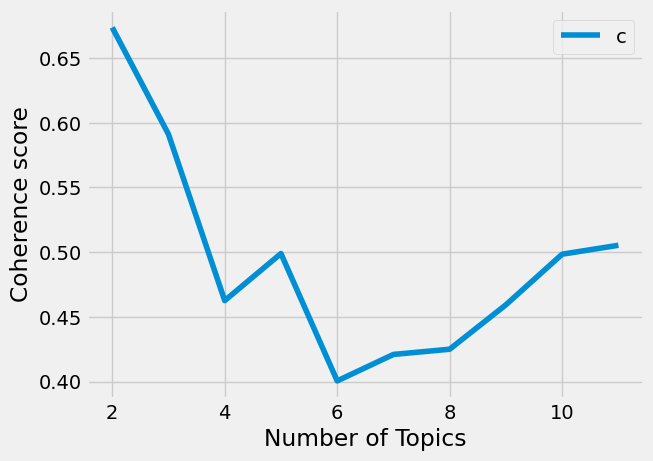

In [46]:
plot_graph(clean_text,start,stop,step)


# Model Creation

In [47]:
from gensim.models import LsiModel

def create_gensim_lsa_model(doc_clean, number_of_topics, words):
    dictionary, tfidf_matrix, tfidf_model = prepare_corpus(doc_clean)

    lsamodel = LsiModel(tfidf_matrix, num_topics=number_of_topics, id2word=dictionary)
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel


In [48]:
summary = df['summary'].dropna().tolist()

# LSA Model
number_of_topics = 7
words = 10
document_list, titles = load_data_from_dataframe(df['summary'])
clean_text=preprocess_data(document_list)
lsamodel=create_gensim_lsa_model(clean_text,number_of_topics,words)

Total Number of Documents: 387
[(0, '-0.243*"menlhk_setjen" + -0.243*"may_june" + -0.243*"stakeholders_follow_progress" + -0.243*"supplier_namely" + -0.243*"gandaerah_hendana" + -0.243*"regularly_order" + -0.243*"tri_bakti" + -0.243*"handling_case" + -0.243*"inecda_plantation" + -0.243*"tracker_updated"'), (1, '0.218*"deforestation" + 0.201*"concession" + 0.163*"indications" + 0.149*"complainant" + 0.119*"allegations" + 0.110*"june" + 0.106*"plantation" + 0.100*"area" + 0.099*"feb" + 0.097*"total"'), (2, '-0.534*"national_park" + -0.292*"tesso_nilo" + -0.292*"alleging_number" + -0.292*"bukit_tigapuluh" + -0.292*"tiger_corridor" + -0.281*"bukit_betabuh" + -0.250*"sourced_ffb" + -0.228*"eof_issued" + -0.129*"gar_purchased" + -0.129*"cpo_contaminated"'), (3, '-0.249*"deforestation" + -0.238*"concession" + -0.237*"indications" + 0.219*"complainant" + -0.165*"feb" + 0.143*"workers" + 0.130*"allegations" + -0.120*"21" + 0.119*"impact_biodiversity" + -0.115*"case_studies"'), (4, '-0.487*"rele

In [49]:
for i, topic in lsamodel.print_topics(num_topics=7, num_words=10):
    print(f"Topic {i}: {topic}\n")

Topic 0: -0.243*"menlhk_setjen" + -0.243*"may_june" + -0.243*"stakeholders_follow_progress" + -0.243*"supplier_namely" + -0.243*"gandaerah_hendana" + -0.243*"regularly_order" + -0.243*"tri_bakti" + -0.243*"handling_case" + -0.243*"inecda_plantation" + -0.243*"tracker_updated"

Topic 1: 0.218*"deforestation" + 0.201*"concession" + 0.163*"indications" + 0.149*"complainant" + 0.119*"allegations" + 0.110*"june" + 0.106*"plantation" + 0.100*"area" + 0.099*"feb" + 0.097*"total"

Topic 2: -0.534*"national_park" + -0.292*"tesso_nilo" + -0.292*"alleging_number" + -0.292*"bukit_tigapuluh" + -0.292*"tiger_corridor" + -0.281*"bukit_betabuh" + -0.250*"sourced_ffb" + -0.228*"eof_issued" + -0.129*"gar_purchased" + -0.129*"cpo_contaminated"

Topic 3: -0.249*"deforestation" + -0.238*"concession" + -0.237*"indications" + 0.219*"complainant" + -0.165*"feb" + 0.143*"workers" + 0.130*"allegations" + -0.120*"21" + 0.119*"impact_biodiversity" + -0.115*"case_studies"

Topic 4: -0.487*"released_september" + -0

# Coherence Score

In [25]:
dictionary, _ , _ = prepare_corpus(clean_text)

coherence_model = CoherenceModel(model=lsamodel, texts=clean_text, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
coherence_score

0.45066268751894833

# Visualizations



What is the Dominant topic and its percentage contribution in each document?

In [27]:
#Input: LSA model, corpus (in this case TFIDF matrix), text (summary column)
#Output: Dataframe consisting of every row
def format_topics_sentences(model=None, corpus=None, texts=None):
    # Collect rows in a list
    rows = []

    for i, doc in enumerate(lsamodel[corpus]):
        sorted_doc = sorted(doc, key=lambda x: abs(x[1]), reverse=True)
        topic_num, prop_topic = sorted_doc[0]
        topic_keywords = ", ".join([word for word, _ in lsamodel.show_topic(topic_num)])
        rows.append([int(topic_num), round(prop_topic, 4), topic_keywords, texts[i]])

    # Create DataFrame from list of rows
    sent_topics_df = pd.DataFrame(rows, columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'Text'])
    return sent_topics_df

In [28]:
def format_topics_sentences(model=None, corpus=None, texts=None):
    rows = []

    for i, doc in enumerate(model[corpus]):
        if not doc:
            # If the model returns an empty list (no topics), skip or insert default
            rows.append([None, 0.0, "", texts[i]])
            continue

        sorted_doc = sorted(doc, key=lambda x: abs(x[1]), reverse=True)
        topic_num, prop_topic = sorted_doc[0]
        topic_keywords = ", ".join([word for word, _ in model.show_topic(topic_num)])
        rows.append([int(topic_num), round(prop_topic, 4), topic_keywords, texts[i]])

    df = pd.DataFrame(rows, columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'Text'])
    return df


In [29]:
_ , tfidf_matrix , _ = prepare_corpus(clean_text)

df_topic_sents_keywords = format_topics_sentences(model=lsamodel, corpus=tfidf_matrix, texts=document_list)

# Format
dominant_topic_df = df_topic_sents_keywords.reset_index()
dominant_topic_df.columns = ['Document_Num', 'Dominant_Topic', 'Topic_%_Contrib', 'Keywords', 'Text']
dominant_topic_df.head(10)

,Document_Num,Dominant_Topic,Topic_%_Contrib,Keywords,Text
0,0,4,0.1399,"concession, 2018, complainant, indications, de...",That the Respondent allegedly transferred the ...
1,1,4,0.1345,"concession, 2018, complainant, indications, de...",The Complainant alleges that the Respondent ha...
2,2,4,0.1742,"concession, 2018, complainant, indications, de...",1.The Complainant alleges that the Respondent ...
3,3,1,-0.0628,"2018, concession, deforestation, complainant, ...",The Respondent's Corporate Social Responsibili...
4,4,1,-0.1862,"2018, concession, deforestation, complainant, ...",The Complainant alleges that the Respondent br...
5,5,4,0.1111,"concession, 2018, complainant, indications, de...",1. The Complainant alleges that he informed th...
6,6,1,-0.0618,"2018, concession, deforestation, complainant, ...",The Respondent has allegedly conducted land cl...
7,7,4,0.0738,"concession, 2018, complainant, indications, de...",The Complainant alleges that the Respondent ha...
8,8,4,0.1347,"concession, 2018, complainant, indications, de...",The Complainant alleges that the Respondent is...
9,9,4,0.1746,"concession, 2018, complainant, indications, de...",Allegations raised against the Respondent are ...


In [34]:
dominant_topic_df[dominant_topic_df['Dominant_Topic'] == 0]

,Document_Num,Dominant_Topic,Topic_%_Contrib,Keywords,Text
308,308,0,-1.0,"menlhk_setjen, inecda_plantation, supplier_nam...","In May/June 2021, Eyes On the Forest (EOF) pub..."
309,309,0,-1.0,"menlhk_setjen, inecda_plantation, supplier_nam...","In May/June 2021, Eyes On the Forest (EOF) pub..."
310,310,0,-1.0,"menlhk_setjen, inecda_plantation, supplier_nam...","In May/June 2021, Eyes On the Forest (EOF) pub..."
311,311,0,-1.0,"menlhk_setjen, inecda_plantation, supplier_nam...","In May/June 2021, Eyes On the Forest (EOF) pub..."
312,312,0,-1.0,"menlhk_setjen, inecda_plantation, supplier_nam...","In May/June 2021, Eyes On the Forest (EOF) pub..."
313,313,0,-1.0,"menlhk_setjen, inecda_plantation, supplier_nam...","In May/June 2021, Eyes On the Forest (EOF) pub..."
314,314,0,-1.0,"menlhk_setjen, inecda_plantation, supplier_nam...","In May/June 2021, Eyes On the Forest (EOF) pub..."
315,315,0,-1.0,"menlhk_setjen, inecda_plantation, supplier_nam...","In May/June 2021, Eyes On the Forest (EOF) pub..."
316,316,0,-1.0,"menlhk_setjen, inecda_plantation, supplier_nam...","In May/June 2021, Eyes On the Forest (EOF) pub..."


## Topic Frequency

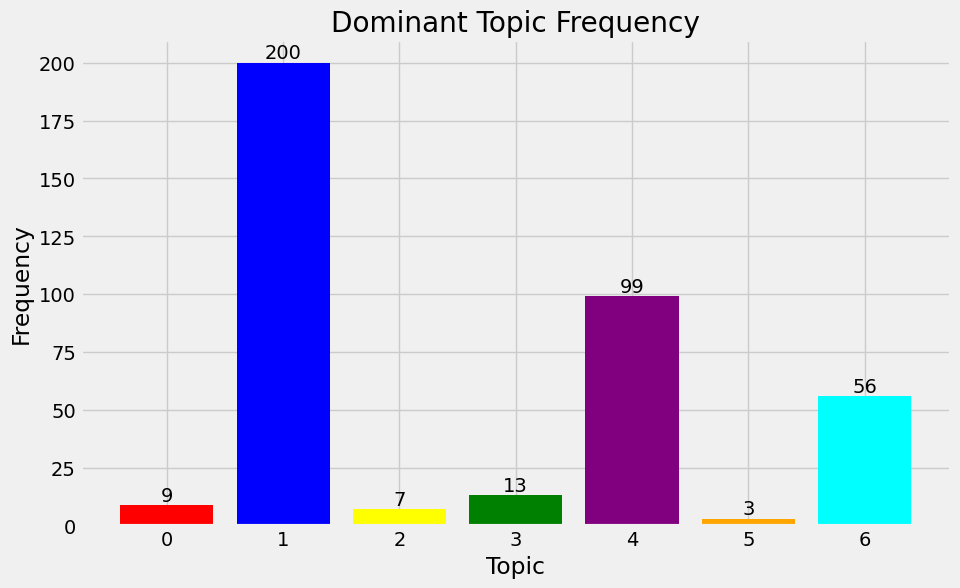

In [31]:
# Prepare data
topics_df = dominant_topic_df.groupby(['Dominant_Topic'])['Document_Num'].count().reset_index()
indexes = topics_df['Dominant_Topic']
values = topics_df['Document_Num']
colors_7 = ['red', 'blue', 'yellow', 'green', 'purple', 'orange', 'cyan']

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(indexes, values, color=colors_7[:len(indexes)])
ax.bar_label(bars)

# Labels and title
ax.set_title('Dominant Topic Frequency')
ax.set_xlabel('Topic')
ax.set_ylabel('Frequency')
plt.show()

## Wordclouds

In [23]:
dominant_topic_df

,Document_Num,Dominant_Topic,Topic_%_Contrib,Keywords,Text
0,0,3,0.0679,"mighty_earth_rapid_response, ha, indications, ...",That the Respondent allegedly transferred the ...
1,1,3,0.1205,"mighty_earth_rapid_response, ha, indications, ...",The Complainant alleges that the Respondent ha...
2,2,3,0.1420,"mighty_earth_rapid_response, ha, indications, ...",1.The Complainant alleges that the Respondent ...
3,3,3,0.0730,"mighty_earth_rapid_response, ha, indications, ...",The Respondent's Corporate Social Responsibili...
4,4,3,0.1391,"mighty_earth_rapid_response, ha, indications, ...",The Complainant alleges that the Respondent br...
...,...,...,...,...,...
382,382,3,0.0934,"mighty_earth_rapid_response, ha, indications, ...",Alleged community rights violations and land c...
383,383,1,-0.0840,"mighty_earth_rapid_response, ha, deforestation...","i. PT Rimba Harapan Saksti (RHS), PT Sarana Ti..."
384,384,1,-0.1054,"mighty_earth_rapid_response, ha, deforestation...",Alleged construction of canal to prepare for d...
385,385,5,0.3697,"biodiversity_leuser_ecosystem, clearance, impa...",Alleged clearance of potential High Carbon Sto...


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


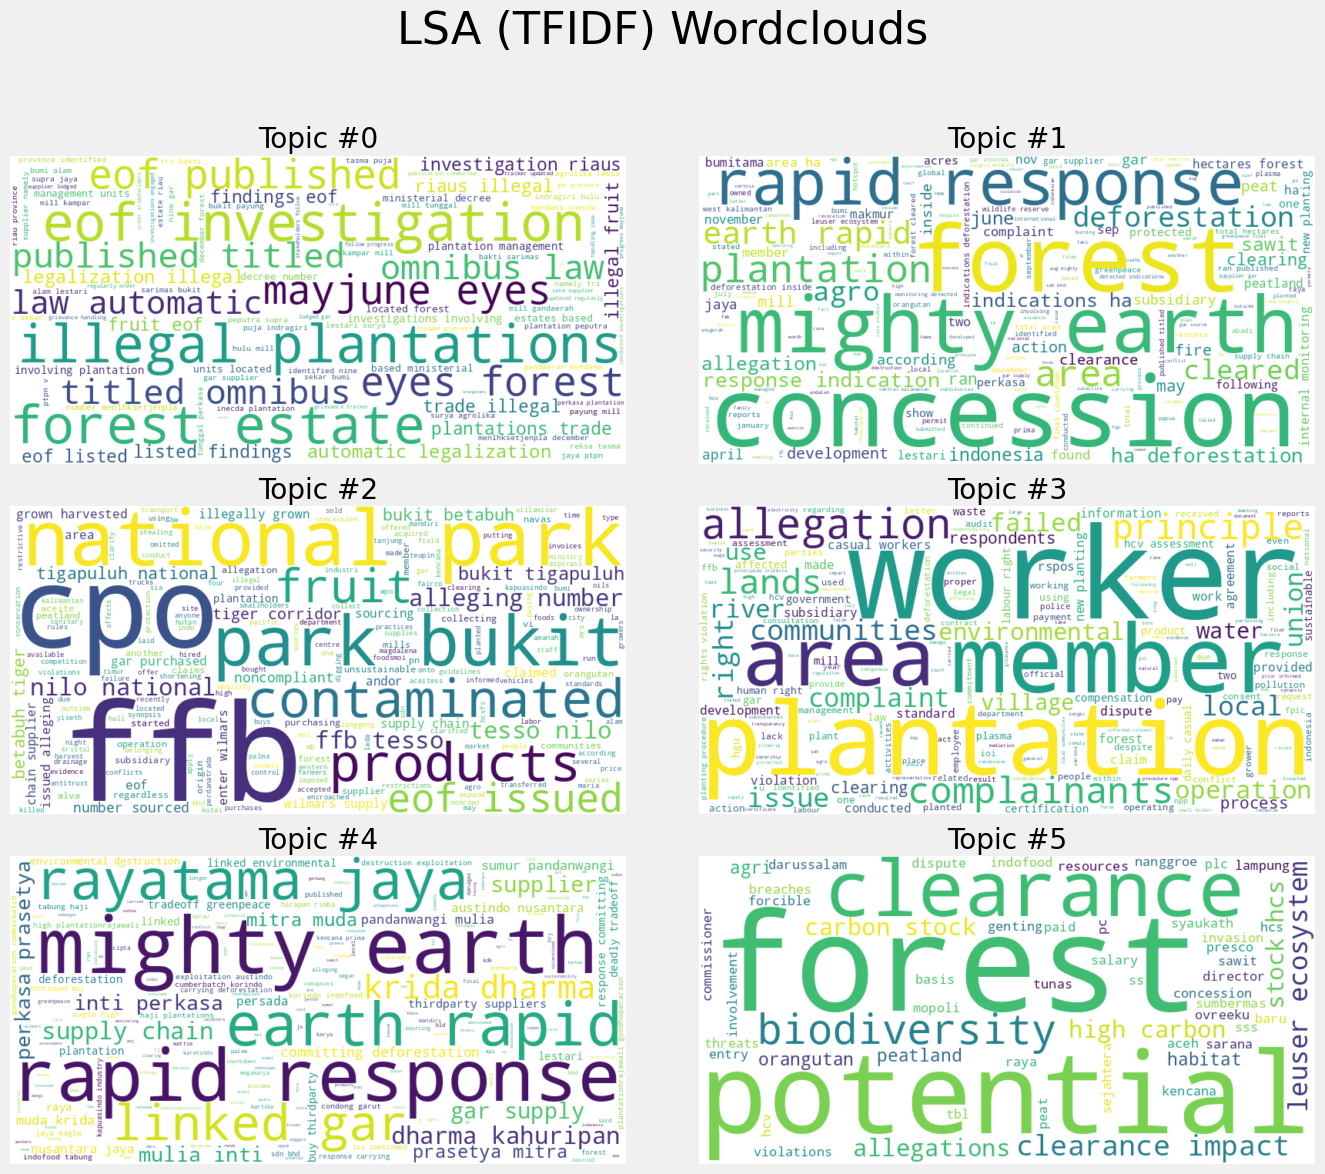

In [24]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re

# Input: Receives dataframe containing all rows with classification, table title, and number of topics
# Output: Displays n word clouds
def display_wordcloud(df, title, n_topics):

  n_cols = 2
  n_rows = int(np.ceil(n_topics / n_cols))
  fig = plt.figure(figsize=(14, 4 * n_rows))

  for topic in range(n_topics):
    topic_df = dominant_topic_df[dominant_topic_df['Dominant_Topic'] == topic]
    text = ' '.join(topic_df['Text'].astype(str).tolist()) # Joining the words of each text of each row into a list separated by ' '
    text = re.sub(r'[^A-Za-z\s]', '', text) # Substituting/deleting anything that IS NOT a letter Aa-Zz with ''
    text = text.lower()
    en_stop = set(stopwords.words('english') + stopwords_extra)
    text = ' '.join(word for word in text.split() if word not in en_stop)

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    ax = fig.add_subplot(n_rows, n_cols, topic + 1)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f"Topic #{topic}")
    ax.axis("off")

  fig.suptitle(title, fontsize=32)
  plt.tight_layout(rect=[0, 0, 1, 0.95])
  plt.show()


display_wordcloud(df=dominant_topic_df, title='LSA (TFIDF) Wordclouds', n_topics=number_of_topics)

In [ ]:
# Find top words in each topic to compare overlap
for idx, topic in enumerate(lsa_model.show_topics(formatted=False)):
    words = [word for word, _ in topic[1]]
    print(f"Topic {idx} words:", words)
